# Load in Packages
It may say you need to restart to update packages, do not or else OSMNX will
not work later on. Just click out of the message and it should still be loading in the packages.

Some chunks may be commented out, that is for ease of grading as they are finniky or connect to google drive

In [ ]:
%%capture
!apt install python3-rtree --quiet
!pip install osmnx
!pip install geopandas
!pip install matplotlib==3.1.3
!pip install pulp
!pip install -q pyomo

import pyomo.environ as pyo
import pulp
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import numpy as np
from google.colab import drive
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
# DO NOT RESTART RUNTIME BC OF MATPLOT LIB

In [ ]:
%%capture
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import osmnx as ox
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#Install Solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

### Read in xlsx files
You need them in your colab files

In [ ]:
school_df = pd.read_excel('/content/middle-school-addresses.xlsx')
fay_addresses_df = pd.read_excel('/content/fay-addresses.xlsx')
addresses_not_in_district_df = pd.read_excel('/content/addresses_not_in_district.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '/content/middle-school-addresses.xlsx'

In [ ]:
# Find the ObjectIDs that are present in both datasets
common_object_ids = pd.merge(
    fay_addresses_df,
    addresses_not_in_district_df,
    on='OBJECTID',
    how='inner'
)['OBJECTID']

# Now filter out these from the in-district DataFrame
filtered_addresses_in_district_df = fay_addresses_df[
    ~fay_addresses_df['OBJECTID'].isin(common_object_ids)
]

In [ ]:
# Save to google drive to download
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Saved to excel to never endure that again
#filtered_addresses_in_district_df.to_excel('/content/drive/My Drive/filtered_addresses_in_district_df.xlsx', index=False)

In [ ]:
# Read in the dataset that we saved so there is no need to rerun above code
filtered_addresses_in_district_df = pd.read_excel('/content/filtered_district_addresses.xlsx')

In [ ]:
filtered_addresses_in_district_df.head()

,OBJECTID,City,ZIP Code,State,Est. Pop.,Street,Address Line 1,Join ID,SUF_UNIT,SHAPE
0,2,FAYETTEVILLE,72701,AR,2.02,324 E 12TH ST,CURRENT RESIDENT,3973,NaN,Point
1,3,FAYETTEVILLE,72701,AR,2.02,903 W 12TH ST,CURRENT RESIDENT,3957,NaN,Point
2,4,FAYETTEVILLE,72701,AR,2.02,834 W 12TH ST,CURRENT RESIDENT,3957,NaN,Point
3,5,FAYETTEVILLE,72704,AR,2.02,2205 W HWY 112,CURRENT RESIDENT,9646,NaN,Point
4,6,FAYETTEVILLE,72701,AR,2.02,1611 E 5TH ST,CURRENT RESIDENT,590,NaN,Point


In [ ]:
# Drop unnecessary columns
filtered_addresses_in_district_df = filtered_addresses_in_district_df.drop(columns = ['SUF_UNIT'])
filtered_addresses_in_district_df = filtered_addresses_in_district_df.drop(columns = ['SHAPE'])
filtered_addresses_in_district_df = filtered_addresses_in_district_df.drop(columns = ['Est. Pop.'])
filtered_addresses_in_district_df = filtered_addresses_in_district_df.drop(columns = ['Address Line 1'])
filtered_addresses_in_district_df = filtered_addresses_in_district_df.drop(columns = ['Join ID'])
filtered_addresses_in_district_df.head()

,OBJECTID,City,ZIP Code,State,Street
0,2,FAYETTEVILLE,72701,AR,324 E 12TH ST
1,3,FAYETTEVILLE,72701,AR,903 W 12TH ST
2,4,FAYETTEVILLE,72701,AR,834 W 12TH ST
3,5,FAYETTEVILLE,72704,AR,2205 W HWY 112
4,6,FAYETTEVILLE,72701,AR,1611 E 5TH ST


In [ ]:
print("Number of rows in original Fayetteville addresses:", fay_addresses_df.shape[0])
print("Number of rows in addresses not in district:", addresses_not_in_district_df.shape[0])
print("Number of rows in filtered Fayetteville addresses:", filtered_addresses_in_district_df.shape[0])

Number of rows in original Fayetteville addresses: 50950
Number of rows in addresses not in district: 6771
Number of rows in filtered Fayetteville addresses: 46324


In [ ]:
#adding state column if needed
filtered_addresses_in_district_df['State'] = 'AR'

# Combine columns to create a full address column for geocoding
filtered_addresses_in_district_df['Full Address'] = (
    filtered_addresses_in_district_df['Street'] + ', ' +
    filtered_addresses_in_district_df['City'] + ', ' +
    filtered_addresses_in_district_df['State'] + ' ' +
    filtered_addresses_in_district_df['ZIP Code'].astype(str)
)


In [ ]:
#adding state column if needed
school_df['State'] = 'AR'

# Combine columns to create a full address column for geocoding
school_df['Full Address'] = (
    school_df['Street'] + ', ' +
    school_df['City'] + ', ' +
    school_df['State'] + ' ' +
    school_df['Zipcode'].astype(str)
)

school_df

,ID,School_Name,Zipcode,Street,City,State,Full Address
0,1,Holt Middle School,72704,2365 Rupple Rd,Fayetteville,AR,"2365 Rupple Rd, Fayetteville, AR 72704"
1,2,John L Colbert Middle School,72704,888 S Rupple Rd,Fayetteville,AR,"888 S Rupple Rd, Fayetteville, AR 72704"
2,3,McNair,72703,3030 E Mission Blvd,Fayetteville,AR,"3030 E Mission Blvd, Fayetteville, AR 72703"


# GeoPy

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="UARK_Proj_abgallem")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [ ]:
#convert from object to string for geolocator
filtered_addresses_in_district_df.dtypes
filtered_addresses_in_district_df['Full Address'] = filtered_addresses_in_district_df['Full Address'].astype("string")

school_df['Full Address'] = school_df['Full Address'].astype("string")

In [ ]:
#test with first row
location = geolocator.geocode(filtered_addresses_in_district_df.iloc[1,5])
print(location.address)
print((location.latitude, location.longitude))

903, West 12th Street, Fayetteville, Washington County, Arkansas, 72701, United States
(36.050574, -94.17297812557291)


In [ ]:
# add cols for middle school df
school_df['location'] = school_df['Full Address'].apply(geocode)
school_df['Lat'] = school_df['location'].apply(lambda x: x.latitude if x else None)
school_df['Lon'] = school_df['location'].apply(lambda x: x.longitude if x else None)

In [ ]:
test_address = filtered_addresses_in_district_df.head(10)  # Test with 10 addresses

test_address['location'] = test_address['Full Address'].apply(geocode)
test_address['Lat'] = test_address['location'].apply(lambda x: x.latitude if x else None)
test_address['Lon'] = test_address['location'].apply(lambda x: x.longitude if x else None)
# Drop NAN location values bc later code will not run with them
test_address = test_address.dropna()
test_address

In [ ]:
# randomly sample 4000 rows (about double the amount of middle schoolers in district)
sample_addresses = filtered_addresses_in_district_df.sample(n=4000, random_state=1)
sample_addresses

# This is commented out for grading purposes, it takes 1+ to run and will randomly crash
# add cols to sample df
#sample_addresses['location'] = sample_addresses['Full Address'].apply(geocode)
#sample_addresses['Lat'] = sample_addresses['location'].apply(lambda x: x.latitude if x else None)
#sample_addresses['Lon'] = sample_addresses['location'].apply(lambda x: x.longitude if x else None)
#sample_addresses

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 537, in _make_request
    response = conn.getresponse()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 461, in getresponse
    httplib_response = super().getresponse()
  File "/usr/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1303, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1159, in read
    return self._sslobj.read(len, buffer)
TimeoutError: The read operation timed out

The above e

,OBJECTID,City,ZIP Code,State,Street,Full Address,location,Lat,Lon
33463,45409,FAYETTEVILLE,72701,AR,1649 S CONWAY PL,"1649 S CONWAY PL, FAYETTEVILLE, AR 72701","(1649, South Conway Place, The Spectrum, Fayet...",36.047008,-94.182616
38334,53247,FAYETTEVILLE,72703,AR,3875 N STEELE BLVD,"3875 N STEELE BLVD, FAYETTEVILLE, AR 72703","(3875, North Steele Boulevard, Uptown Fayettev...",36.122098,-94.157072
5543,7097,FAYETTEVILLE,72703,AR,456 E MARGARET PL,"456 E MARGARET PL, FAYETTEVILLE, AR 72703","(456, East Margaret Place, Fayetteville, Washi...",36.108536,-94.151573
10934,14676,FAYETTEVILLE,72703,AR,4245 NE MEADOW CREEK CIR,"4245 NE MEADOW CREEK CIR , FAYETTEVILLE, AR 72703","(4245, Northeast Meadow Creek Circle, Reserve ...",36.128638,-94.154801
30947,41878,FAYETTEVILLE,72704,AR,3051 W MICA ST,"3051 W MICA ST, FAYETTEVILLE, AR 72704","(3051, West Mica Street, Fayetteville, Washing...",36.080302,-94.207064
...,...,...,...,...,...,...,...,...,...
19135,26095,FAYETTEVILLE,72701,AR,1671 S COLONNADE DR,"1671 S COLONNADE DR, FAYETTEVILLE, AR 72701","(1671, South Colonnade Drive, The Spectrum, Fa...",36.046733,-94.185720
43816,63523,FAYETTEVILLE,72701,AR,1898 W MITCHELL ST,"1898 W MITCHELL ST, FAYETTEVILLE, AR 72701","(1898, West Mitchell Street, Mitchell Yards, F...",36.058298,-94.187138
36496,49533,FAYETTEVILLE,72701,AR,1893 W HUDSON DR,"1893 W HUDSON DR, FAYETTEVILLE, AR 72701","(1893, West Hudson Drive, University House, Fa...",36.054063,-94.187166
16959,23074,FAYETTEVILLE,72701,AR,621 N WILLOW AVE,"621 N WILLOW AVE, FAYETTEVILLE, AR 72701","(621, North Willow Avenue, Fayetteville, Washi...",36.072020,-94.154902


In [ ]:
# Saved to excel to never endure that again
#sample_addresses.to_excel('/content/drive/My Drive/address_sample.xlsx', index=False)

In [ ]:
sample_addresses = pd.read_excel('/content/address_sample.xlsx')

In [ ]:
# Find which locations are unavaliable with geopy
# Delete rows with NAN for Location
print(sample_addresses[sample_addresses['Lat'].isna()])
sample_addresses = sample_addresses.dropna(ignore_index=True)
sample_addresses

# Mapping Distance by Road

In [ ]:
# With test addresses
# Define the list of origin and destination addresses
test_address  # Add your origin addresses
school_df  # Add your destination addresses

# Load the city network
place = "Fayetteville, Arkansas"
G = ox.graph_from_place(place, network_type="drive")

# Initialize an empty list to store distances
distances = {}


# Iterate over origin addresses
for i in range(1, len(test_address)):
    # Fetch the nearest node w.r.t origin address
    origin_node = ox.distance.nearest_nodes(G, test_address['Lon'][i], test_address['Lat'][i])
    # Iterate over destination addresses
    for j in range(len(school_df)):
        # Fetch the nearest node w.r.t destination address
        destination_node = ox.distance.nearest_nodes(G, school_df['Lon'][j], school_df['Lat'][j])

        # Find shortest path
        route_nodes = nx.shortest_path(G, origin_node, destination_node, weight="length")

        # Calculate length of the shortest path
        length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')

        # Append the distances for this origin to the main list
        distances[(i,j)] = (length / 1609)

# Access the distance for address i for destination j
i = 1  # Index of origin address
j = 2  # Index of destination address
distance = distances[i,j]
print("Distance from", test_address.loc[i], "to", school_df.loc[j], ":", distance, "mi")

# Print the distances list
print("All distances:")
print(distances)

Distance from OBJECTID                                                        3
City                                                 FAYETTEVILLE
ZIP Code                                                    72701
State                                                          AR
Street                                              903 W 12TH ST
Full Address                903 W 12TH ST, FAYETTEVILLE, AR 72701
location        (903, West 12th Street, Fayetteville, Washingt...
Lat                                                     36.050574
Lon                                                    -94.172978
Name: 1, dtype: object to ID                                                              3
School_Name                                                McNair
Zipcode                                                     72703
Street                                        3030 E Mission Blvd
City                                                 Fayetteville
State                               

In [ ]:
# Define the list of origin and destination addresses
# This will take roughly 20 minutes to run
sample_addresses  # Add your origin addresses
school_df  # Add your destination addresses

# Load the city network
place = "Fayetteville, Arkansas"
G = ox.graph_from_place(place, network_type="drive")

# Initialize an empty list to store distances
distances = {}


# Iterate over origin addresses
for i in range(len(sample_addresses)):
    # Fetch the nearest node w.r.t origin address
    origin_node = ox.distance.nearest_nodes(G, sample_addresses['Lon'][i], sample_addresses['Lat'][i])

    # Iterate over destination addresses
    for j in range(len(school_df)):
        # Fetch the nearest node w.r.t destination address
        destination_node = ox.distance.nearest_nodes(G, school_df['Lon'][j], school_df['Lat'][j])

        # Find shortest path
        route_nodes = nx.shortest_path(G, origin_node, destination_node, weight="length")

        # Calculate length of the shortest path
        length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')

        # Add the address key pair and the miles value
        distances[i,j] = length / 1609  # Convert to miles


# Access the distance for address i for destination j
i = 0  # Index of origin address
j = 1  # Index of destination address
distance = distances[i,j]
print("Distance from", sample_addresses.loc[i], "to", school_df.loc[j], ":", distance, "mi")

# Print the distances list
print("All distances:")
print(distances)

Distance from OBJECTID                                                    45409
City                                                 FAYETTEVILLE
ZIP Code                                                    72701
State                                                          AR
Street                                           1649 S CONWAY PL
Full Address             1649 S CONWAY PL, FAYETTEVILLE, AR 72701
location        1649, South Conway Place, The Spectrum, Fayett...
Lat                                                     36.047008
Lon                                                    -94.182616
Name: 0, dtype: object to ID                                                              2
School_Name                          John L Colbert Middle School
Zipcode                                                     72704
Street                                            888 S Rupple Rd
City                                                 Fayetteville
State                               

# Optimization


In [ ]:
# Pull just Latitude and Longitude
students_df = sample_addresses[['Lat', 'Lon']]
schools_df = school_df[['Lat', 'Lon']]


In [ ]:
num_addresses = len(sample_addresses) # Currently roughly 2000 middle schoolers, doubled for the sake of model
# Matches index from distances
num_schools = [0,1,2] # Starts from 0 bc of how ij in distances is indexed
capacities = [920, 1600, 1396] # The current capacities for 2023-2024 are 460, 800, 698. The capacities are doubled bc the students are for this model

In [ ]:
len(distances)
# Test the range of distances, see if it is from 0-3857 or 1-3858
distances[3858,0]
# Error means 3858 isnt included

In [ ]:
# Define the model
model = pyo.ConcreteModel()

In [ ]:
# Define the sets
# The range needs to match the indexed distances dict
# RangeSet is inclusive
model.students = pyo.RangeSet(0,3857)
model.schools = pyo.Set(initialize=num_schools)

In [ ]:
# Check sets
print(model.schools.pprint())
print(model.students.pprint())

schools : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    3 : {0, 1, 2}
None
students : Dimen=1, Size=3858, Bounds=(0, 3857)
    Key  : Finite : Members
    None :   True : [0:3857]
None


In [ ]:
# Define the decision variables
model.x = pyo.Var(model.students, model.schools, domain=pyo.Binary)
# Define the params
model.distances = pyo.Param(model.students, model.schools, initialize=distances)

In [ ]:
# Define the objective function
def objective_rule(model):
    return sum(distances[i,j] * model.x[i,j] for i in model.students for j in model.schools)

model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

In [ ]:
# Define the constraints
def assignment_rule(model, i):
    return sum(model.x[i,j] for j in model.schools) == 1
model.assignment_constraint = pyo.Constraint(model.students, rule=assignment_rule)

def capacity_rule(model, j):
    return sum(model.x[i,j] for i in model.students) <= capacities[j]
model.capacity_constraint = pyo.Constraint(model.schools, rule=capacity_rule)

In [ ]:
opt = pyo.SolverFactory('/content/bin/cbc')
#Solve the model
results = opt.solve(model)
results.write()
#Access and print the objective value
print("objective=", pyo.value(model.objective))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3861
  Number of variables: 11574
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CBC 2.10.10 optimal, objective 11050.423771908; 0 nodes, 0 iterations, 1.94864 seconds
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.8650565147399902
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of sol

In [ ]:
# Processing the results
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):

    for i in model.students:
        for j in model.schools:
            if pyo.value(model.x[i,j]) == 1:
                print(f"Address {i} is assigned to School {j}")

else:
    print("Solution is not optimal")

In [ ]:
# Count for the number of addresses assigned to each school
holt = 0
colbert = 0
mcnair = 0
for i in model.students:
    if pyo.value(model.x[i,0] == 1):
      holt += 1
    if pyo.value(model.x[i,1] == 1):
      colbert += 1
    if pyo.value(model.x[i,2] == 1):
      mcnair += 1

print('Students at Holt:',holt)
print('Students at John L Colbert:',colbert)
print('Students at McNair:' ,mcnair)
print((holt + colbert + mcnair) == num_addresses)

Students at Holt: 920
Students at John L Colbert: 1542
Students at McNair: 1396
True


In [ ]:
# Assign a color for each j value when its the optimal value
color = []

for i in model.students:
      if pyo.value(model.x[i,0]) == 1:
        color.append('lemonchiffon')
      elif pyo.value(model.x[i,1]) == 1:
        color.append('#ADD8E6')
      elif pyo.value(model.x[i,2]) == 1:
        color.append('#B6D7A8')
      else:
        print("Solution is not optimal")

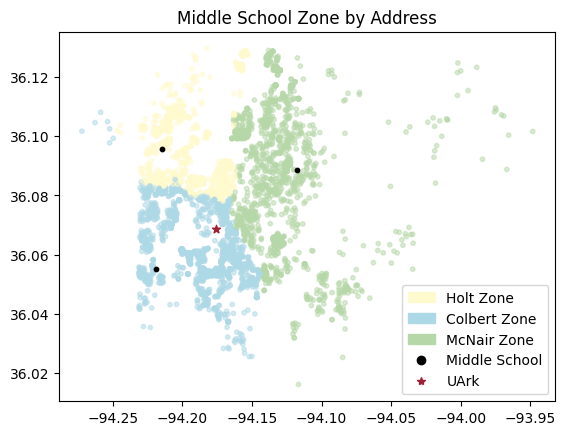

In [ ]:
#graphing the results to see where everything is, long is x, lat is y
# Black is schools
plt.scatter(sample_addresses['Lon'], sample_addresses['Lat'], color = color, s = 10, alpha = .5, label=color)
plt.scatter(school_df['Lon'], school_df['Lat'],color = 'k', s=10)
plt.scatter(-94.176012, 36.068681, marker='*', color='#9D2235')
holt_zone = mpatches.Patch(color='lemonchiffon', label='Holt Zone')
colbert_zone = mpatches.Patch(color='#ADD8E6', label='Colbert Zone')
mcnair_zone = mpatches.Patch(color='#B6D7A8', label='McNair Zone')
middleschools = Line2D([0], [0], label='Middle School',marker = 'o', color='k', linestyle='')
uark = Line2D([0], [0], label='UArk',marker = '*', color='#9D2235', linestyle='')

plt.legend(handles=[holt_zone, colbert_zone, mcnair_zone, middleschools, uark])
plt.title('Middle School Zone by Address')
plt.show()